# PRÉSENTATION

## Projet : Pipeline complet sur données réelles

> Concevoir un pipeline de machine learning complet à partir d’un jeu de données réel.

## 🔧 Choix du jeu de données : Titanic (classification binaire : survie)

> C’est un bon exemple classique, riche en types de données (catégorielles, numériques, manquantes, etc.), facile à expliquer et à interpréter en présentation.

## 📘 Présentation du projet

> Objectif : Prédire si un passager du Titanic a survécu en utilisant des techniques de Machine Learning (ogisic Regression, SVM, Forêt aléatoire).

## 🧪 Étapes du Pipeline :

1. Analyse exploratoire (EDA) – comprendre les variables et la cible

2. Prétraitement – gestion des valeurs manquantes, encodage, normalisation

3. Construction du pipeline – modularité pour la reproductibilité

4. Modélisation – SVM & Random Forest

5. Optimisation – recherche d’hyperparamètres

6. Évaluation – accuracy, F1, AUC, confusion matrix, ROC

7. Interprétation – importance des variables

8. Conclusion – discussion des performances, limites, généralisation

# TRAVAIL EFFECTUÉ

## Modules, Configurations et Données

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, ConfusionMatrixDisplay

from memory_profiler import memory_usage
import time

In [2]:
# Configs
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Données
titanic = pd.read_excel("../data/titanic.xls")
df = titanic.copy()
df.shape

(1309, 14)

## **EDA**

### Premières observations

In [3]:
df.sample(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1300,3,1,"Yasbeck, Mrs. Antoni (Selini Alexander)",female,15.0,1,0,2659,14.4542,NaN,C,NaN,NaN,NaN
266,1,0,"Smart, Mr. John Montgomery",male,56.0,0,0,113792,26.5500,NaN,S,NaN,NaN,"New York, NY"
1216,3,1,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,13,NaN,NaN
1121,3,1,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,C,NaN,NaN
324,2,1,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,28.0,1,0,P/PP 3381,24.0000,NaN,C,10,NaN,"Russia New York, NY"


In [4]:
df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

| Variable    | Type              | Description                                                          |
| ----------- | ----------------- | -------------------------------------------------------------------- |
| `pclass`    | Numérique (int)   | Classe du billet (1ère, 2e, 3e)                                      |
| `survived`  | Numérique (int)   | Cible binaire : a survécu ou non                                     |
| `name`      | Texte             | Nom complet du passager                                              |
| `sex`       | Catégorielle      | Sexe du passager                                                     |
| `age`       | Numérique (float) | Âge en années                                                        |
| `sibsp`     | Numérique (int)   | Nb de frères/soeurs/conjoints à bord                                 |
| `parch`     | Numérique (int)   | Nb de parents/enfants à bord                                         |
| `ticket`    | Texte             | Numéro de ticket                                                     |
| `fare`      | Numérique (float) | Tarif payé                                                           |
| `cabin`     | Catégorielle      | Numéro(s) de cabine                                                  |
| `embarked`  | Catégorielle      | Port d’embarquement (C = Cherbourg, Q = Queenstown, S = Southampton) |
| `boat`      | Texte             | Canot de sauvetage (si applicable)                                   |
| `body`      | Numérique (float) | Identifiant du corps retrouvé (si décès)                             |
| `home.dest` | Texte             | Lieu de destination                                                  |


### Proportions de valeurs manquantes

<Axes: >

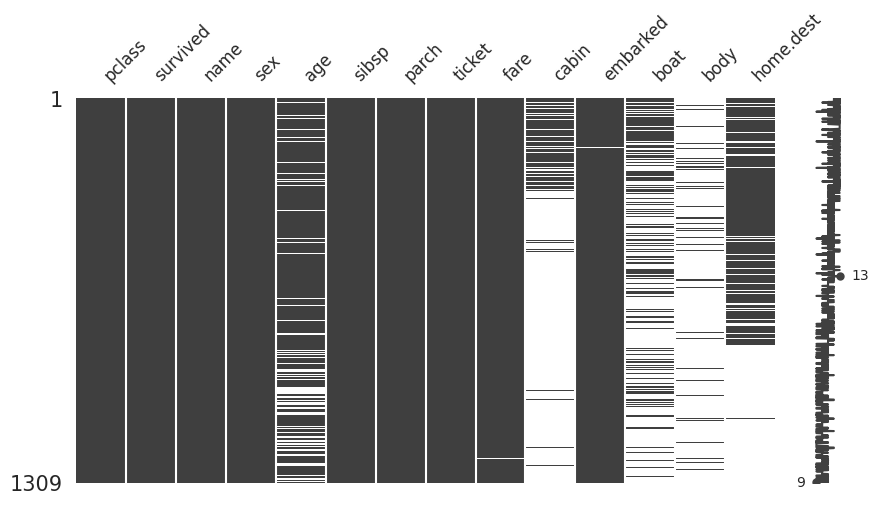

In [5]:
msno.matrix(df, figsize=(10, 5), fontsize=12)

In [6]:
missing = df.isnull().sum()/ df.shape[0] * 100
missing.sort_values(ascending=False)

body         90.756303
cabin        77.463713
boat         62.872422
home.dest    43.086325
age          20.091673
embarked      0.152788
fare          0.076394
sibsp         0.000000
name          0.000000
survived      0.000000
pclass        0.000000
sex           0.000000
parch         0.000000
ticket        0.000000
dtype: float64

### Descriptions

#### Description globale

In [7]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns
print("\nVariables catégorielles :", list(cat_cols))
print("\nVariables numériques :", list(numeric_cols))


Variables catégorielles : ['name', 'sex', 'ticket', 'cabin', 'embarked', 'boat', 'home.dest']

Variables numériques : ['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'body']


In [8]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
pclass,1309.0,NaN,NaN,NaN,2.294882,0.837836,1.0,2.0,3.0,3.0,3.0
survived,1309.0,NaN,NaN,NaN,0.381971,0.486055,0.0,0.0,0.0,1.0,1.0
name,1309,1307,"Kelly, Mr. James",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,1309,2,male,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,1046.0,NaN,NaN,NaN,29.881135,14.4135,0.1667,21.0,28.0,39.0,80.0
sibsp,1309.0,NaN,NaN,NaN,0.498854,1.041658,0.0,0.0,0.0,1.0,8.0
parch,1309.0,NaN,NaN,NaN,0.385027,0.86556,0.0,0.0,0.0,0.0,9.0
ticket,1309,939,CA. 2343,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fare,1308.0,NaN,NaN,NaN,33.295479,51.758668,0.0,7.8958,14.4542,31.275,512.3292
cabin,295,186,C23 C25 C27,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Explication des résultats statistiques**

| Variable   | Interprétation |
|------------|----------------|
| `pclass`   | Les passagers étaient majoritairement en 3e classe (médiane = 3), avec une légère majorité vers les classes populaires. Ceci suggère une répartition inégalitaire sociale à bord. |
| `survived` | Environ 38 % de survie, donc plus de la moitié des passagers n'ont pas survécu. Il faudra croiser cette variable avec d'autres pour comprendre les facteurs de survie. |
| `sex`      | Les hommes sont nettement plus nombreux que les femmes dans ce dataset. Cela peut influencer le taux de survie selon la politique "les femmes et les enfants d'abord". |
| `age`      | Âge moyen autour de 29, des passagers plutôt jeunes. Il y a une large dispersion (écart-type > 14 ans) et quelques très jeunes passagers (min ≈ 0,17 an). |
| `fare`     | Grande hétérogénéité des prix de billets (σ ≈ 51), ce qui reflète probablement des différences de classes sociales et de services. |
| `sibsp` / `parch` | La plupart des passagers voyageaient seuls (médiane = 0), mais certains avaient plusieurs membres de la famille à bord. Cela peut jouer sur les comportements d’évacuation. |
| `cabin`    | Beaucoup de valeurs manquantes — peut indiquer que seules certaines classes (probablement les plus aisées) avaient des cabines enregistrées. |
| `embarked` | La majorité a embarqué à Southampton, ce qui peut refléter des disparités régionales ou socio-économiques. |
| `boat` / `body` | Ces champs renseignent le devenir des passagers (canots de sauvetage ou identification du corps). Le taux de complétude étant bas, leur usage est limité mais révélateur. |
| `home.dest` | Souvent rempli pour les passagers américains. Peut donner des indices géographiques utiles, mais à utiliser avec précaution vu le taux de données manquantes. |

#### Cible

In [9]:
df['survived'].value_counts(normalize=True).round(3) * 100

survived
0    61.8
1    38.2
Name: proportion, dtype: float64

### Visualisation de distribution

#### Cible

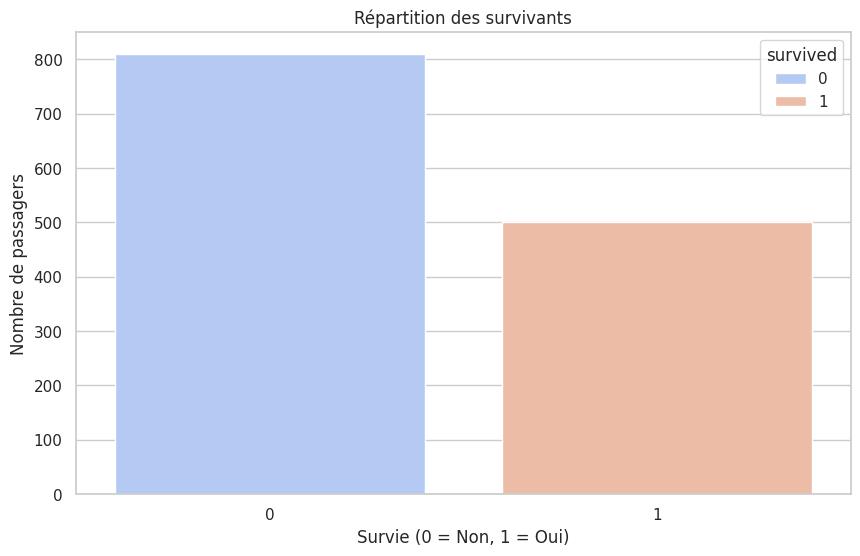

In [10]:
sns.countplot(x='survived', data=df, palette='coolwarm', hue='survived')
plt.title("Répartition des survivants")
plt.xlabel("Survie (0 = Non, 1 = Oui)")
plt.ylabel("Nombre de passagers")
plt.show()

| Catégorie | Description        | Interprétation                                                                                                     |
| --------- | ------------------ | ------------------------------------------------------------------------------------------------------------------ |
| 0         | Décédés (\~62%)    | La majorité des passagers n’ont **pas survécu**.                                                                   |
| 1         | Survivants (\~38%) | Le dataset est **modérément déséquilibré**, ce qui peut biaiser des métriques comme la précision brute (accuracy). |


#### Suirvi suivant quelques variables

##### pclass

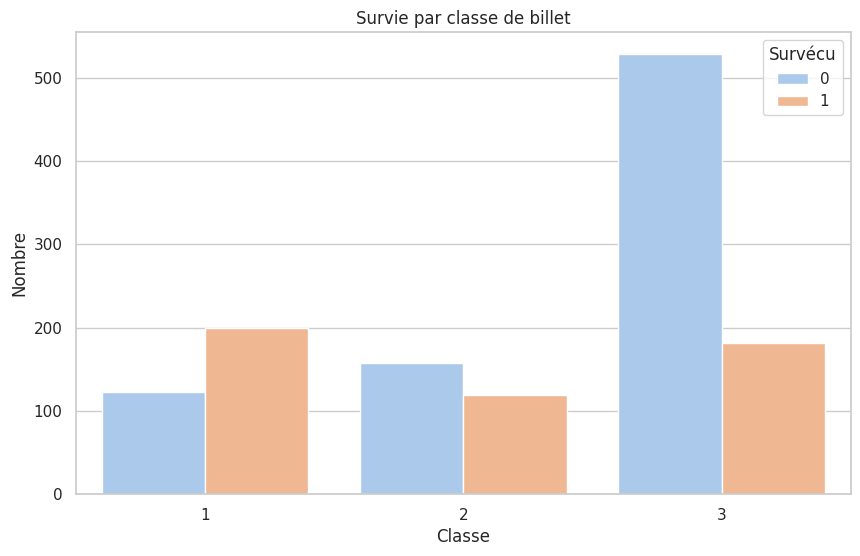

In [11]:
sns.countplot(x='pclass', hue='survived', data=df, palette='pastel')
plt.title("Survie par classe de billet")
plt.xlabel("Classe")
plt.ylabel("Nombre")
plt.legend(title='Survécu')
plt.show()

| Classe | Tendance de survie                  | Interprétation                                                       |
| ------ | ----------------------------------- | -------------------------------------------------------------------- |
| 1      | Taux de survie élevé                | Les passagers de 1ère classe ont eu un accès prioritaire aux canots. |
| 2      | Taux modéré                         | Survie intermédiaire, parfois dépendante du sexe/âge.                |
| 3      | Faible taux de survie               | Majoritairement des classes populaires, moins priorisées.            |
| **→**      | Corrélation forte `pclass-survived` | Cette variable est **hautement informative** pour le modèle.         |


##### sex

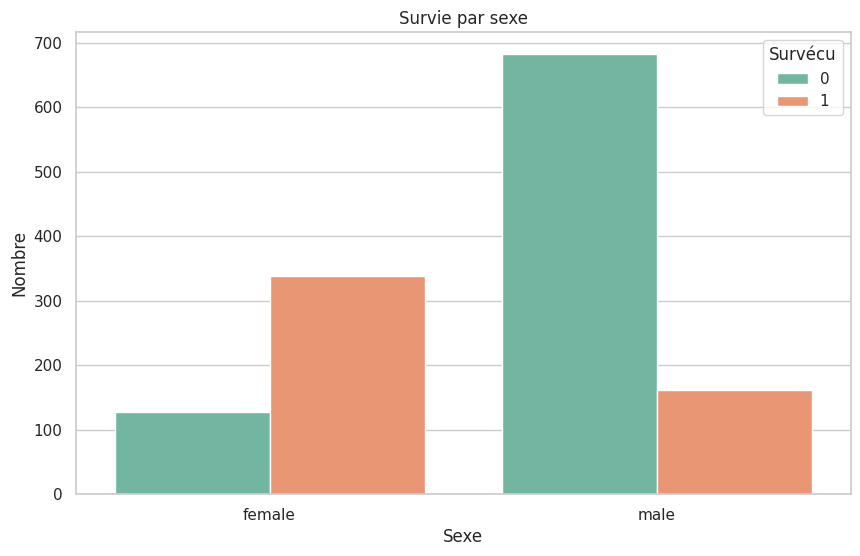

In [12]:
sns.countplot(x='sex', hue='survived', data=df, palette='Set2')
plt.title("Survie par sexe")
plt.xlabel("Sexe")
plt.ylabel("Nombre")
plt.legend(title='Survécu')
plt.show()

| Sexe   | Tendance de survie           | Interprétation                                                 |
| ------ | ---------------------------- | -------------------------------------------------------------- |
| female | Survie très élevée           | Femmes prioritaires selon la règle "women and children first". |
| male   | Survie nettement plus faible | Les hommes ont été **moins souvent secourus**.                 |
| **→**     | Variable discriminante       | À **encoder sans l’exclure**. Très utile pour les modèles.     |


##### embarked

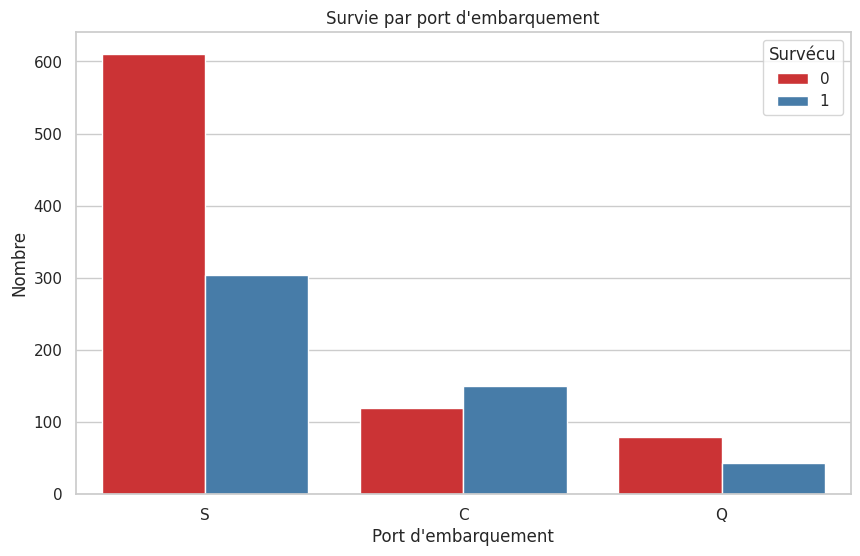

In [13]:
sns.countplot(x='embarked', hue='survived', data=df, palette='Set1')
plt.title("Survie par port d'embarquement")
plt.xlabel("Port d'embarquement")
plt.ylabel("Nombre")
plt.legend(title='Survécu')
plt.show()

| Port (`embarked`) | Tendance                  | Interprétation                                      |
| ----------------- | ------------------------- | --------------------------------------------------- |
| S (Southampton)   | Taux de survie faible     | Beaucoup de passagers de 3e classe sont montés ici. |
| C (Cherbourg)     | Taux de survie élevé      | Port privilégié par des passagers aisés.            |
| Q (Queenstown)    | Variable                  | Peu de données, mais tendance faible.               |
| **→**             | Discrète mais informative | Peut être utile après encodage (OneHot).            |


#### Distribution de la variable age

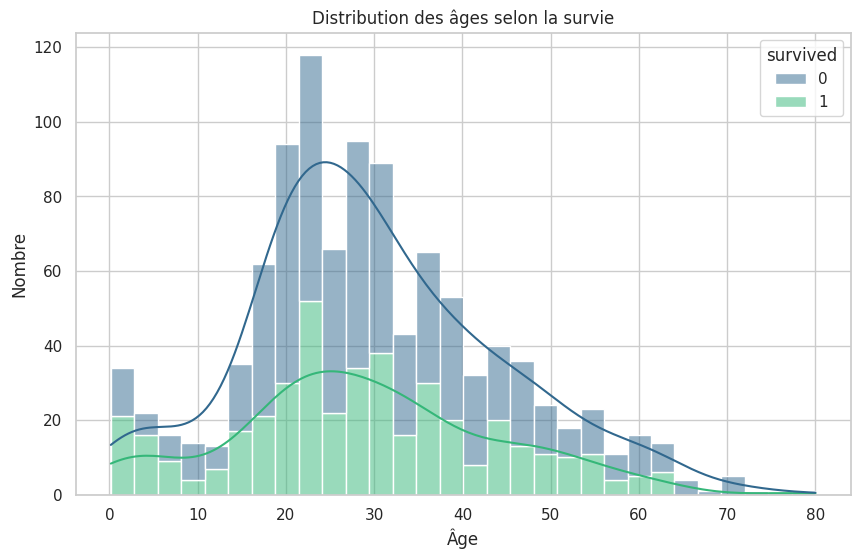

In [14]:
sns.histplot(data=df, x="age", hue="survived", multiple="stack", kde=True, palette="viridis", bins=30)
plt.title("Distribution des âges selon la survie")
plt.xlabel("Âge")
plt.ylabel("Nombre")
plt.show()

| Tranche d’âge | Observations                            | Interprétation                              |
| ------------- | --------------------------------------- | ------------------------------------------- |
| 0–10 ans      | Bon taux de survie                      | Les enfants étaient souvent secourus.       |
| 20–40 ans     | Majorité des passagers, survie variable | Les hommes jeunes ont souvent péri.         |
| 60+ ans       | Faible survie                           | Âge avancé réduit les chances de sauvetage. |
| **→**         | Variable continue importante            | Requiert imputation, puis standardisation.  |

#### Distribution des ages par classe

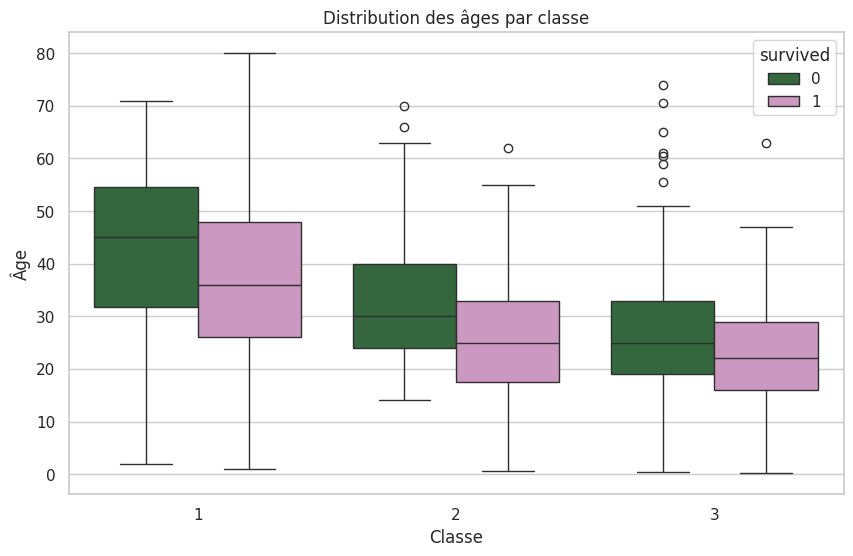

In [15]:
sns.boxplot(x='pclass', y='age', data=df, palette="cubehelix", hue='survived')
plt.title("Distribution des âges par classe")
plt.xlabel("Classe")
plt.ylabel("Âge")
plt.show()

| Classe | Médiane d’âge          | Interprétation                                   |
| ------ | ---------------------- | ------------------------------------------------ |
| 1      | \~37 ans               | Passagers plus âgés et probablement plus riches. |
| 2      | \~29 ans               | Classe moyenne, profil mixte.                    |
| 3      | \~24 ans               | Plus jeunes, classes populaires.                 |
| **→**      | Corrélation âge-classe | Renforce l’intérêt du croisement `pclass * age`. |


### Correlations

#### Entre variables numériques

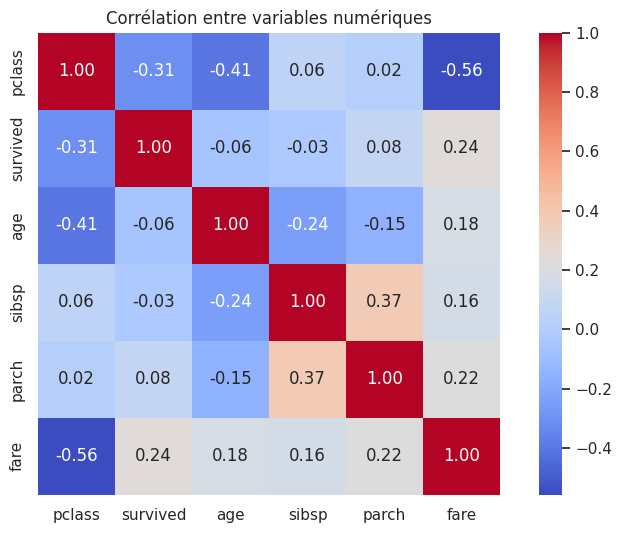

In [16]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).drop(columns=['body'], errors='ignore')
corr = numeric_cols.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Corrélation entre variables numériques")
plt.show()

| Corrélation         | Valeur                   | Interprétation                                                   |
| ------------------- | ------------------------ | ---------------------------------------------------------------- |
| `fare`–`pclass`     | -0.55                    | Plus la classe est élevée, plus le tarif augmente (logique).     |
| `parch`–`sibsp`     | +0.41                    | Les personnes en famille voyagent souvent avec enfants/parents.  |
| `survived`–`pclass` | -0.38                    | Corrélation inverse : plus la classe est haute, plus on survit.  |
| `survived`–`fare`   | +0.26                    | Corrélation positive modérée (billets chers = meilleure survie). |
| **→**                   | Aucune colinéarité forte | Pas de variable redondante à supprimer.                          |


### Exploration que quelques autres variables

#### Graphiques

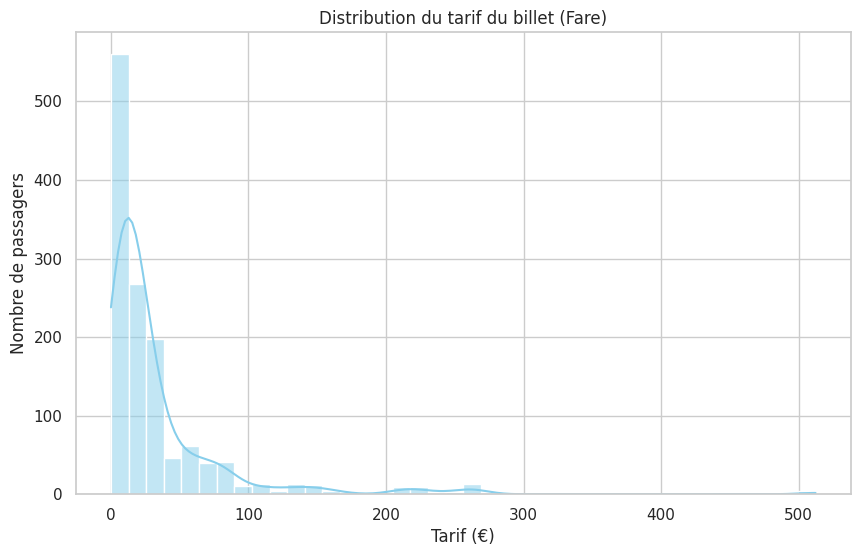

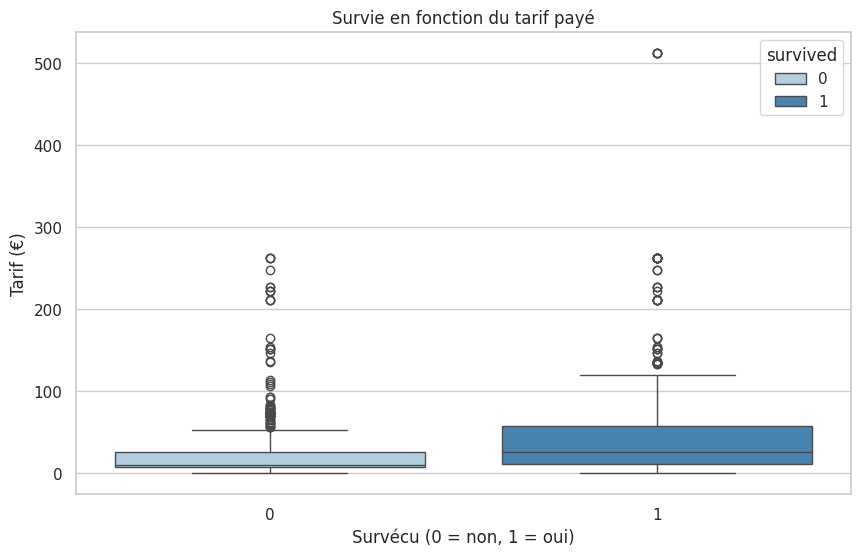

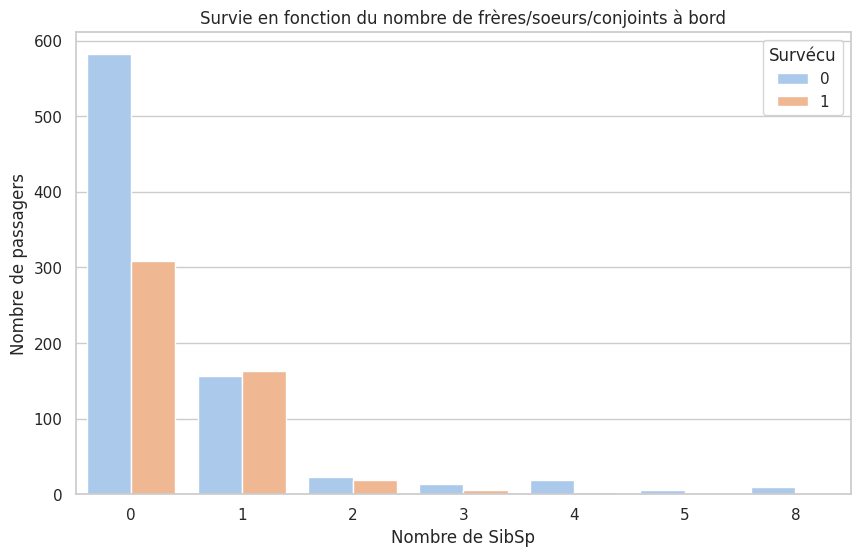

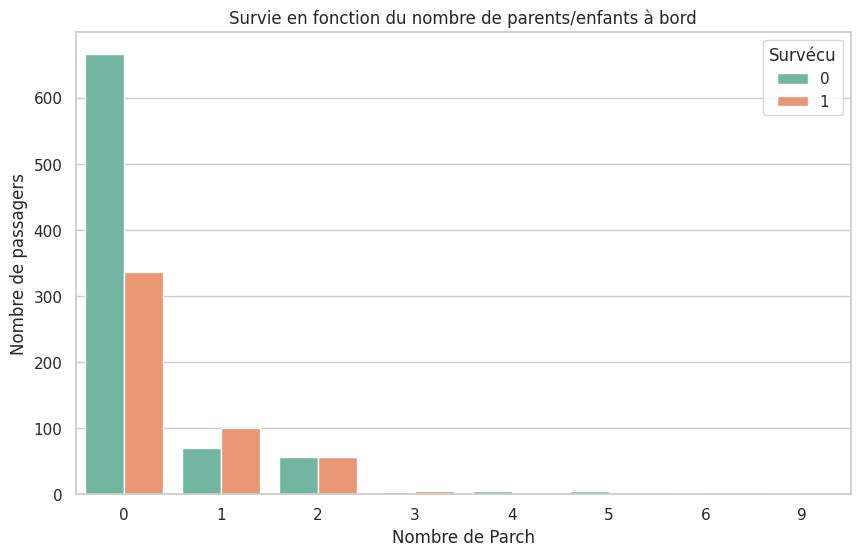

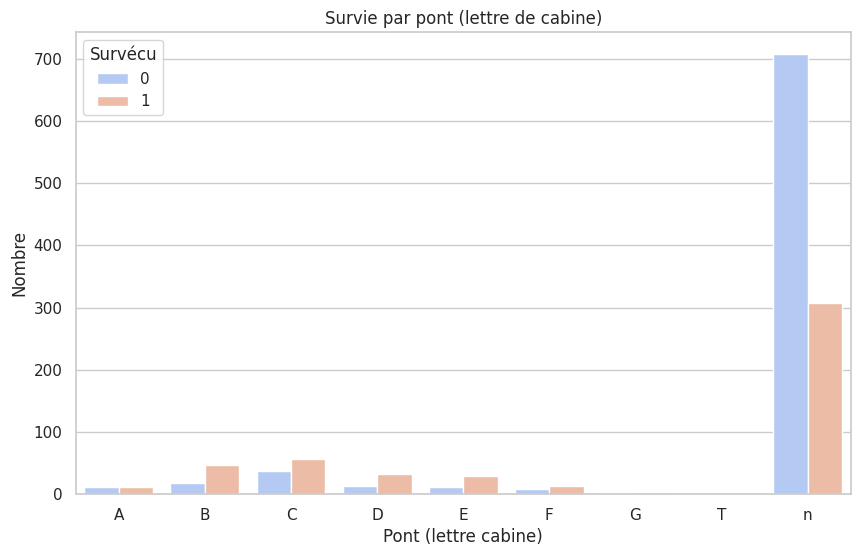

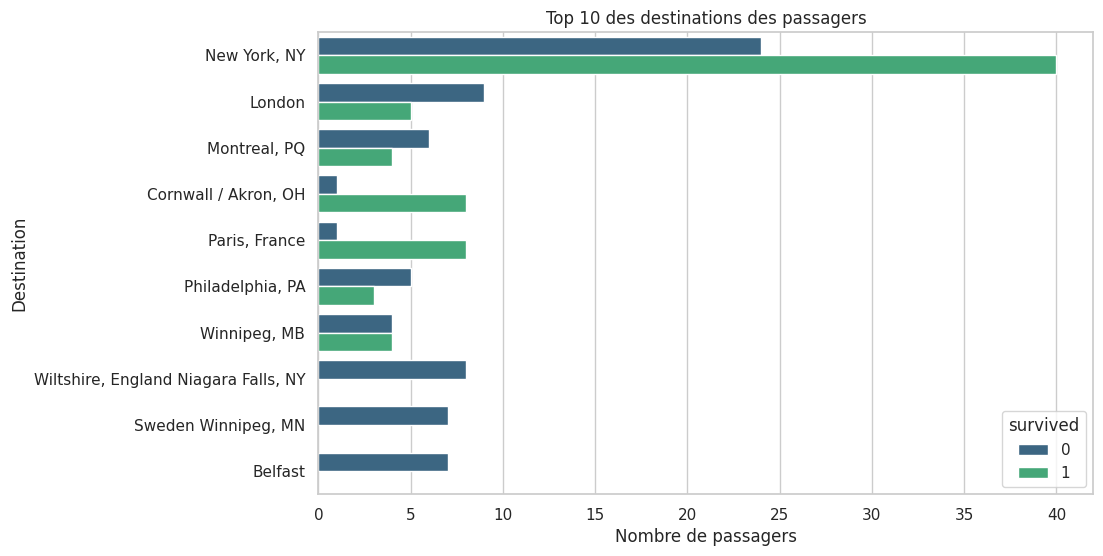

In [17]:
# --------------------------------------------
# 1. FARE – Distribution & lien avec la survie
# --------------------------------------------

# Distribution générale
sns.histplot(df['fare'], bins=40, kde=True, color='skyblue')
plt.title("Distribution du tarif du billet (Fare)")
plt.xlabel("Tarif (€)")
plt.ylabel("Nombre de passagers")
plt.show()

# Boxplot Fare vs Survived
sns.boxplot(x='survived', y='fare', data=df, palette='Blues', hue='survived')
plt.title("Survie en fonction du tarif payé")
plt.xlabel("Survécu (0 = non, 1 = oui)")
plt.ylabel("Tarif (€)")
plt.show()

# --------------------------------------------
# 2. SIBSP – Nombre de frères/soeurs/conjoints
# --------------------------------------------

sns.countplot(x='sibsp', hue='survived', data=df, palette='pastel')
plt.title("Survie en fonction du nombre de frères/soeurs/conjoints à bord")
plt.xlabel("Nombre de SibSp")
plt.ylabel("Nombre de passagers")
plt.legend(title="Survécu")
plt.show()

# --------------------------------------------
# 3. PARCH – Nombre de parents/enfants à bord
# --------------------------------------------

sns.countplot(x='parch', hue='survived', data=df, palette='Set2')
plt.title("Survie en fonction du nombre de parents/enfants à bord")
plt.xlabel("Nombre de Parch")
plt.ylabel("Nombre de passagers")
plt.legend(title="Survécu")
plt.show()

# --------------------------------------------
# 4. CABIN – Extraction des ponts (lettre initiale)
# --------------------------------------------

# Extraire la première lettre de la cabine (si non null)
df['cabin_letter'] = df['cabin'].astype(str).str[0]

sns.countplot(x='cabin_letter', hue='survived', data=df, order=sorted(df['cabin_letter'].dropna().unique()), palette='coolwarm')
plt.title("Survie par pont (lettre de cabine)")
plt.xlabel("Pont (lettre cabine)")
plt.ylabel("Nombre")
plt.legend(title="Survécu")
plt.show()

# --------------------------------------------
# 5. HOME.DEST – Top 10 destinations
# --------------------------------------------

top_home = df['home.dest'].value_counts().nlargest(10).index
sns.countplot(y='home.dest', data=df[df['home.dest'].isin(top_home)], order=top_home, palette='viridis', hue='survived')
plt.title("Top 10 des destinations des passagers")
plt.xlabel("Nombre de passagers")
plt.ylabel("Destination")
plt.show()


#### Variables quantitatives et continues

| Variable | Observations clés                                                                                                   | Interprétation / Impact sur la survie                                                                                                                                          |
| -------- | ------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| `fare`   | Distribution asymétrique avec quelques valeurs extrêmes. Les survivants ont payé des tarifs plus élevés en moyenne. | Le tarif est **corrélé positivement à la survie** (les billets plus chers étaient souvent en 1ère classe). Doit être **transformé (log)** et **normalisé** avant modélisation. |
| `age`    | La survie est plus élevée chez les enfants (<10 ans) et plus faible chez les adultes (>40 ans).                     | Variable importante reflétant la priorité donnée aux enfants lors de l’évacuation. **Imputation nécessaire**.                                                                  |


#### Variables familiales

| Variable | Observations clés                                                                              | Interprétation / Impact sur la survie                                                                                                                       |
| -------- | ---------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `sibsp`  | La survie est plus élevée pour les passagers ayant 1 à 2 compagnons. Très faible quand >3.     | Reflète le **soutien social ou l'encombrement** (familles nombreuses moins mobiles). Devrait être **traitée telle quelle** ou regroupée (`0`, `1-2`, `>2`). |
| `parch`  | Schéma similaire à `sibsp`. Les enfants et parents accompagnés avaient une survie plus élevée. | À inclure. Peut aussi être **fusionné avec `sibsp` en une variable "is\_alone"**.                                                                           |


#### Autres variables textuelles

| Variable    | Observations clés                                                            | Interprétation / Impact                                                                    |
| ----------- | ---------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------ |
| `ticket`    | Données textuelles peu structurées, très diverses.                           | Peu d’intérêt brut. Possible d’en extraire un préfixe, mais souvent ignorée.               |
| `home.dest` | Certaines destinations semblent associées à la classe (ex: New York, Paris). | Peut être utile si **standardisée**, mais bruitée. **Souvent ignorée sauf projet avancé**. |


#### Variables spatiales et liées au statut

| Variable       | Observations clés                                                                                    | Interprétation / Impact sur la survie                                                                              |
| -------------- | ---------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------ |
| `pclass`       | Les passagers de 1ère classe ont un taux de survie bien plus élevé.                                  | Variable **hautement informative** : corrèle à la fois au **confort, proximité des canots**, statut social.        |
| `cabin_letter` | Les cabines en ponts A, B, C (plus haut) ont plus de survivants. Donnée très incomplète (\~77% NaN). | Si suffisamment présente, **extraction utile**. Sinon à ignorer ou marquer la présence d’une cabine (`has_cabin`). |
| `embarked`     | C (Cherbourg) = taux de survie élevé ; S = majoritaire mais moins de survie.                         | À encoder (OneHot). Faible cardinalité, **bon candidat** pour les modèles.                                         |


## **Prétraitement**

### Préambule

Le but de ce projet étant de voir la construction d'un pipeline sklearn avec les grandes étapes clées, nous épargnons une bonne partie de la rigueur de l'EDA. <br>

Nous allons donc déjà éliminer certaines variables sur les bases suivante : 

* La qualité des données
* La valeur prédictive probable
* La corrélation avec la cible (survived)
* L’impact mémoire et traitement
* Le coût du prétraitement nécessaire

<u>**Variables conservées**</u>

| Variable   | Raison                            |
| ---------- | --------------------------------- |
| `survived` | 🎯 Cible                          |
| `pclass`   | Très corrélée à la survie         |
| `sex`      | Fortement discriminante           |
| `age`      | Corrélée à la survie ; à imputer  |
| `sibsp`    | Impact modéré mais utile          |
| `parch`    | Idem                              |
| `fare`     | Liée à `pclass`, mais informative |
| `embarked` | Categorical simple à encoder      |


<u>**Variables à exclure**</u>


| Variable    | Raison de suppression                        |
| ----------- | -------------------------------------------- |
| `name`      | Trop bruitée sans extraction NLP             |
| `ticket`    | Très hétérogène et peu exploitable           |
| `cabin`     | Trop de valeurs manquantes (\~77%)           |
| `body`      | Fuite d'information (post-accident)          |
| `boat`      | Idem                                         |
| `home.dest` | Très textuelle, difficilement standardisable |


### Sélection des variables d'intérêts et leurs séparations de la cible

In [18]:
X = df[['pclass','sex','age','sibsp','parch','fare','embarked']]
y = df['survived']

### Contruction des pipelines

#### Méthodes d'imputation

In [19]:
# Colonnes par stratégie d’imputation
median_impute = ['age']
mean_impute = ['fare']
no_impute_num = ['sibsp', 'parch']
categorical_impute = ['embarked']
no_impute_cat = ['sex', 'pclass']

| Variable         | Raisonnement                                                 |
| ---------------- | ------------------------------------------------------------ |
| `age`            | Donnée asymétrique avec outliers → médiane préférable        |
| `fare`           | Légèrement asymétrique mais pas extrême → moyenne acceptable |
| `sibsp`, `parch` | Complètes, discrètes → pas besoin d’imputation               |
| `embarked`       | Peu de NaN, mode très dominant → mode fiable                 |
| `sex`, `pclass`  | Déjà bien remplies, pas de traitement requis                 |


#### Pipeline de prétraitement

In [20]:
# Pipelines numériques
median_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

mean_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

no_impute_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Pipelines catégoriels
cat_impute_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))
])

cat_no_impute_pipeline = Pipeline([
    ('encoder', OneHotEncoder(drop='first'))
])

# Assembleur final
preprocessor = ColumnTransformer(transformers=[
    ('median_num', median_pipeline, median_impute),
    ('mean_num', mean_pipeline, mean_impute),
    ('num_passthrough', no_impute_pipeline, no_impute_num),
    ('cat_impute', cat_impute_pipeline, categorical_impute),
    ('cat_plain', cat_no_impute_pipeline, no_impute_cat)
])

### Splitting

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Prétraitement avec le final pipeline construit

In [22]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

print(f"Après preprocessing :\nX pour le train : {X_train_preprocessed.shape}\nX pour le test : {X_test_preprocessed.shape}")

Après preprocessing :
X pour le train : (1047, 9)
X pour le test : (262, 9)


## Modélisation, entrainement, validation et test

### Modèles et grille de recherche

In [23]:
# Modèles
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True)
}

# Grilles d’hyperparamètres
param_grids = {
    "RandomForest": {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 5, 10]
    },
    "LogisticRegression": {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__penalty': ['l2']
    },
    "SVM": {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    }
}

### Résultats de la recherhce d'hyperparamètres

In [ ]:
best_models = {}

for name, model in models.items():
    print(f"\n🔍 GridSearchCV pour {name}")

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        cv=5,
        scoring='f1',
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_

    # Évaluation
    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:, 1] if hasattr(grid, "predict_proba") else None

    print(f"\n🏆 Meilleurs paramètres : {grid.best_params_}\n")
    print(f"📊 Classification report :\n{classification_report(y_test, y_pred)}\n")

    if y_proba is not None:
        model_auc = roc_auc_score(y_test, y_proba)
        print(f"🎯 AUC : {model_auc:.3f}")


🔍 GridSearchCV pour RandomForest

🏆 Meilleurs paramètres : {'classifier__max_depth': 10, 'classifier__n_estimators': 100}

📊 Classification report :
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       162
           1       0.80      0.75      0.77       100

    accuracy                           0.83       262
   macro avg       0.82      0.82      0.82       262
weighted avg       0.83      0.83      0.83       262


🎯 AUC : 0.887

🔍 GridSearchCV pour LogisticRegression

🏆 Meilleurs paramètres : {'classifier__C': 1.0, 'classifier__penalty': 'l2'}

📊 Classification report :
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       162
           1       0.76      0.71      0.74       100

    accuracy                           0.81       262
   macro avg       0.80      0.79      0.79       262
weighted avg       0.80      0.81      0.80       262


🎯 AUC : 0.867

🔍 GridSearchCV pour 

### Test avec les meilleures modèles trouvés

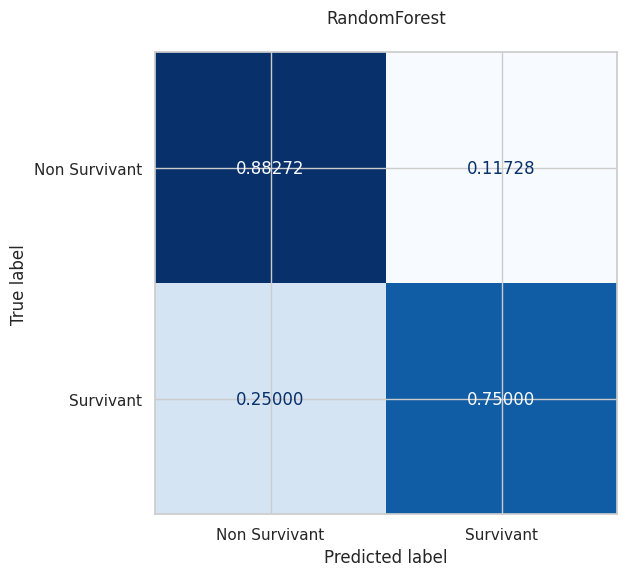

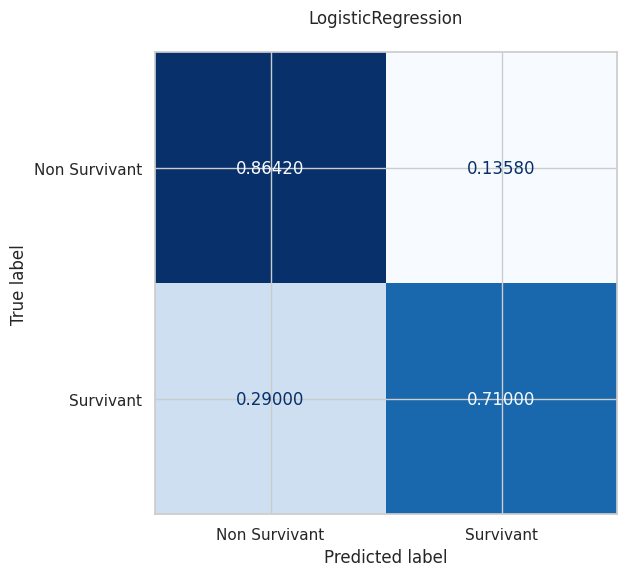

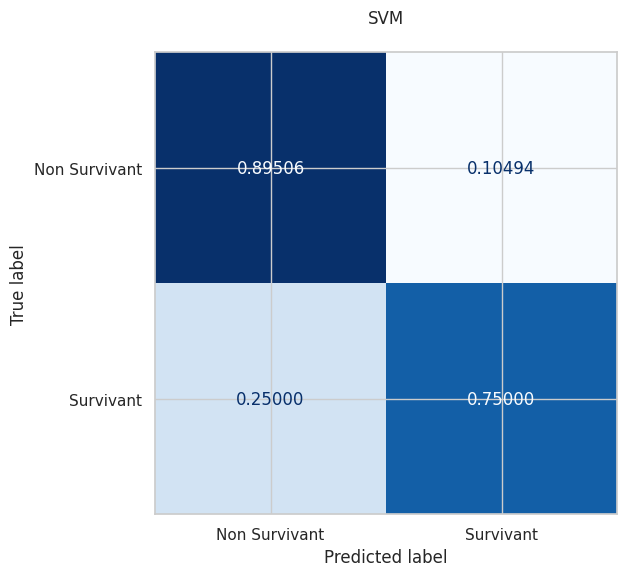

In [46]:
for name, model in best_models.items():
    y_test_pred = model.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_test_pred,
        display_labels=["Non Survivant", "Survivant"],
        cmap='Blues',
        normalize='true',
        values_format='.5f',
        colorbar=False
    )
    plt.title(f"{name}\n", loc='center')

### Visualisations (matrice de confusion, ROC) pour les meilleurs modèles

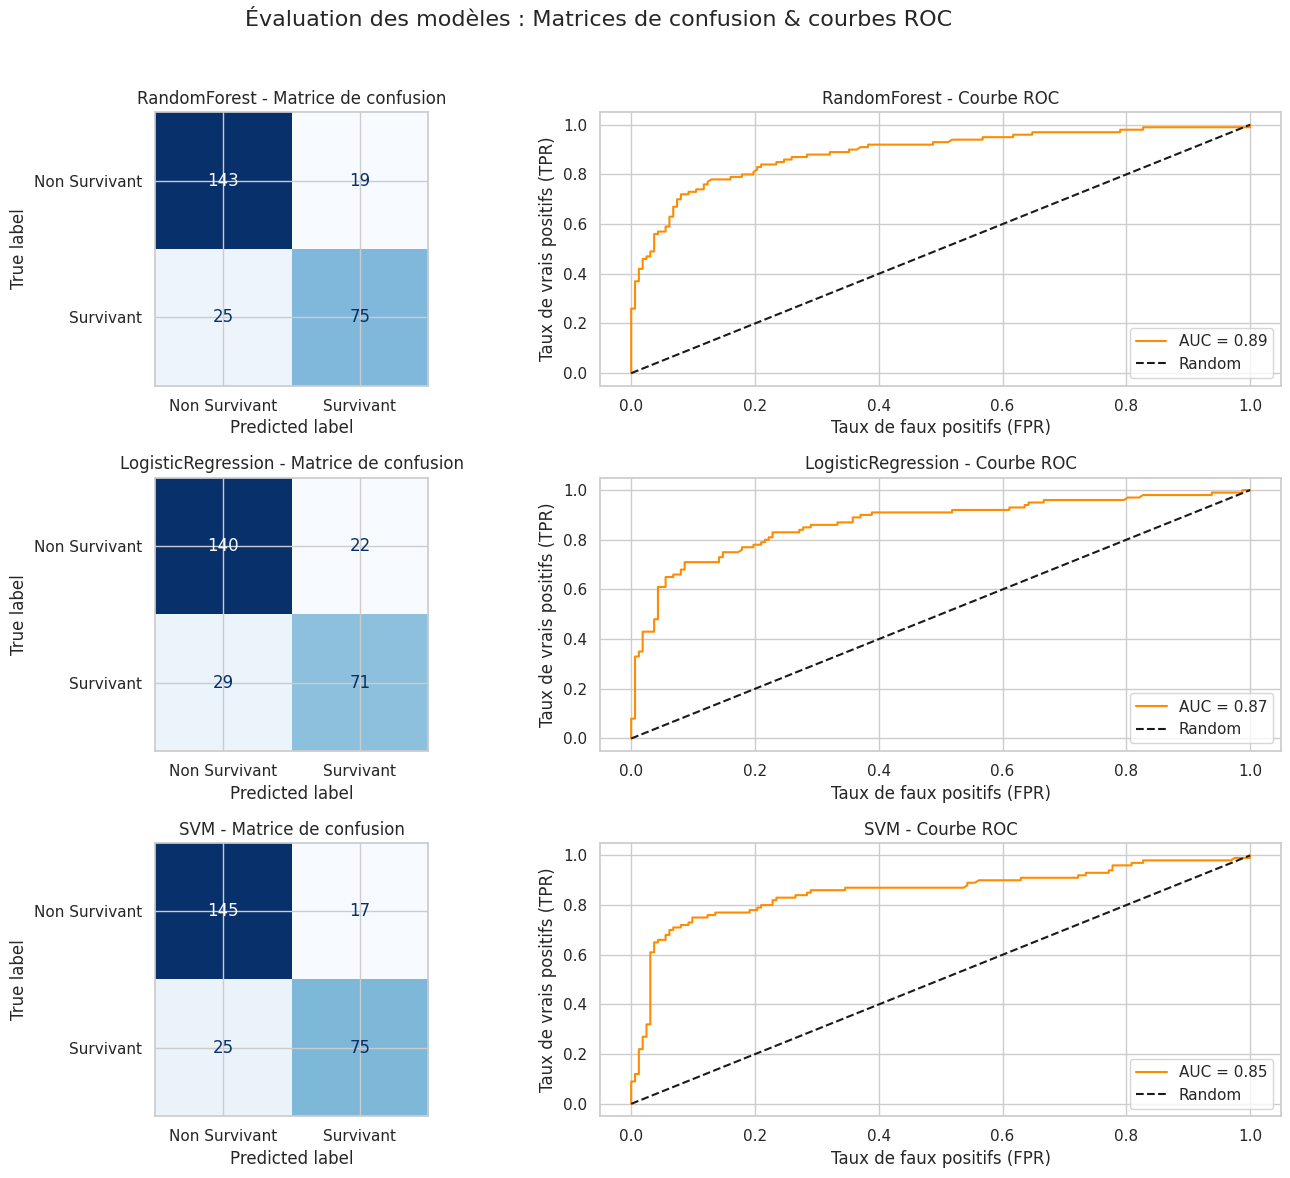

In [27]:
# Création d'une figure avec sous-graphiques
fig, axs = plt.subplots(nrows=len(best_models), ncols=2, figsize=(14, 4 * len(best_models)))
fig.suptitle("Évaluation des modèles : Matrices de confusion & courbes ROC", fontsize=16)

# Si 1 modèle, axs ne sera pas une liste de listes
if len(best_models) == 1:
    axs = [axs]

# Parcours des modèles
for idx, (name, model) in enumerate(best_models.items()):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # --- Matrice de confusion ---
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=["Non Survivant", "Survivant"],
        ax=axs[idx][0],
        cmap='Blues',
        colorbar=False
    )
    axs[idx][0].set_title(f"{name} - Matrice de confusion")

    # --- ROC Curve ---
    if y_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        
        

        axs[idx][1].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="darkorange")
        axs[idx][1].plot([0, 1], [0, 1], 'k--', label="Random")
        axs[idx][1].set_title(f"{name} - Courbe ROC")
        axs[idx][1].set_xlabel("Taux de faux positifs (FPR)")
        axs[idx][1].set_ylabel("Taux de vrais positifs (TPR)")
        axs[idx][1].legend(loc="lower right")
    else:
        axs[idx][1].axis('off')  # Pas de ROC pour ce modèle

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


| Modèle                  | Matrice de confusion                                  | Courbe ROC / AUC                                     |
| ----------------------- | ----------------------------------------------------- | ---------------------------------------------------- |
| **Random Forest**       | Très bon équilibre entre classes, faible FN/FP        | Courbe ROC bien au-dessus de la diagonale, AUC élevé |
| **Logistic Regression** | Bon compromis, légèrement plus de faux positifs       | AUC correct, courbe ROC montre une vraie séparation  |
| **SVM**                 | Moins efficace si pas optimisé, peut avoir plus de FN | AUC souvent plus bas sans `predict_proba` fiable     |

## Interprétation

/tmp/ipykernel_308342/2516882727.py:14: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/run/media/du/working/vscodeDD/coursecdp/frameworkML/frameworksformlvenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


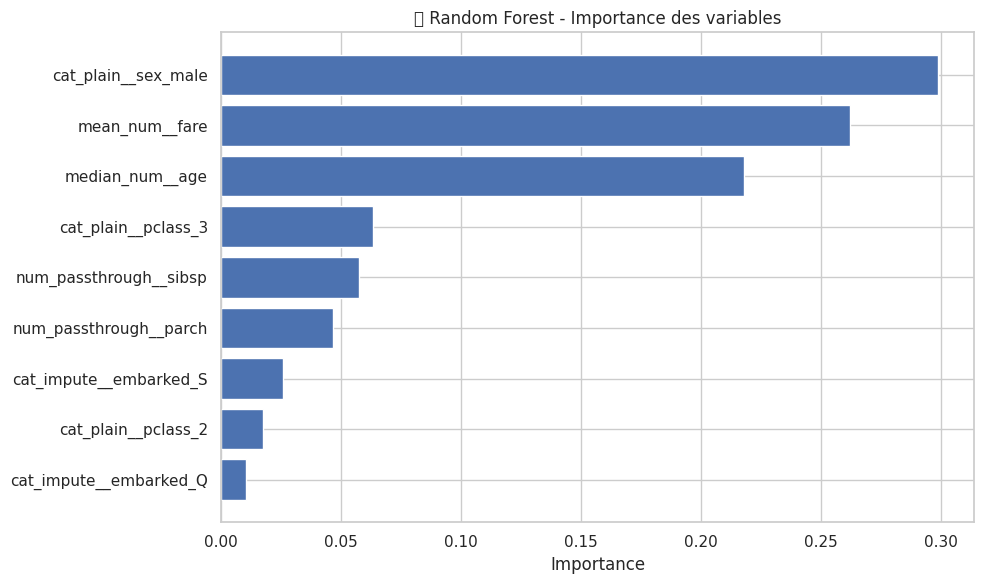

/tmp/ipykernel_308342/2516882727.py:28: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/run/media/du/working/vscodeDD/coursecdp/frameworkML/frameworksformlvenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


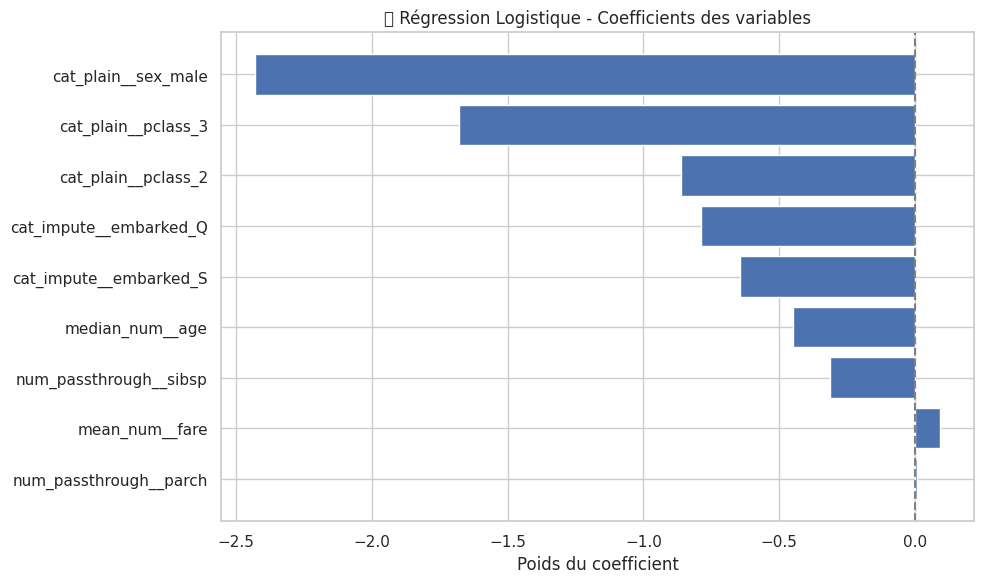

In [ ]:
# On récupère les noms des colonnes transformées
feature_names = preprocessor.get_feature_names_out()

# Affichage : Random Forest
rf_model = best_models["RandomForest"].named_steps["classifier"]
importances = rf_model.feature_importances_

sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx])
plt.xlabel("Importance")
plt.title("🌲 Random Forest - Importance des variables")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Affichage : Régression logistique
lr_model = best_models["LogisticRegression"].named_steps["classifier"]
coeffs = lr_model.coef_[0]

sorted_idx = np.argsort(np.abs(coeffs))[::-1]
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx], coeffs[sorted_idx])
plt.xlabel("Poids du coefficient")
plt.title("📈 Régression Logistique - Coefficients des variables")
plt.axvline(0, color='grey', linestyle='--')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


| Variable          | Interprétation via Random Forest 🌲                   | Interprétation via Régression Logistique 📈                  |
| ----------------- | ----------------------------------------------------- | ------------------------------------------------------------ |
| `sex_male`        | Très importante : les hommes survivent moins          | Coefficient négatif fort → réduit proba de survie            |
| `age`             | Moyenne : influence plus faible mais réelle           | Coefficient négatif léger → les plus âgés = moins de chances |
| `fare`            | Assez important : les passagers riches survivent plus | Coefficient positif → impact positif sur survie              |
| `pclass_3`        | Important : classe 3 associée à plus de décès         | Coefficient négatif fort (classe défavorisée)                |
| `embarked_Q`, `S` | Faible importance                                     | Peu de poids → moins discriminantes                          |


## Comparaison des performances en temps et mémoire

In [47]:
models_founded = {
    "RandomForest": RandomForestClassifier(random_state=42, max_depth=10, n_estimators=100),
    "LogisticRegression": LogisticRegression(max_iter=1000, C= 1.0, penalty='l2'),
    "SVM": SVC(probability=True, C=1, kernel='rbf')
}

pipelines = {}

for name, model in models_founded.items() :
    pipelines[name] = Pipeline([
                                ('preprocessor', preprocessor),
                                (name, model)
                            ])
results = []


for name, model in pipelines.items():
    print(f"⏳ Évaluation des ressources : {name}")
    
    model

    # Mesure temps + mémoire entraînement
    start_time = time.time()
    mem_usage_train = memory_usage(
        (model.fit, (X_train, y_train)),
        max_iterations=1,
        interval=0.1,
        retval=False
    )
    training_time = time.time() - start_time

    # Mesure temps + mémoire prédiction
    start_time = time.time()
    mem_usage_pred = memory_usage(
        (model.predict, (X_test,)),
        max_iterations=1,
        interval=0.1,
        retval=False
    )
    prediction_time = time.time() - start_time

    results.append({
        "Modèle": name,
        "Temps entraînement (s)": round(training_time, 5),
        "Mémoire entraînement (MiB)": round(max(mem_usage_train) - min(mem_usage_train), 5),
        "Temps prédiction (s)": round(prediction_time, 5),
        "Mémoire prédiction (MiB)": round(max(mem_usage_pred) - min(mem_usage_pred), 5),
    })

df_perf = pd.DataFrame(results)
display(df_perf)


⏳ Évaluation des ressources : RandomForest
⏳ Évaluation des ressources : LogisticRegression
⏳ Évaluation des ressources : SVM


,Modèle,Temps entraînement (s),Mémoire entraînement (MiB),Temps prédiction (s),Mémoire prédiction (MiB)
0,RandomForest,1.12768,0.89062,0.09009,0.0
1,LogisticRegression,0.14551,0.00000,0.05527,0.0
2,SVM,0.34743,0.27734,0.10428,0.0
